<a href="https://colab.research.google.com/github/Elangoraj/LandCover-Image-Classification/blob/main/LandCover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download images**

In [ ]:
!mkdir Dataset
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip 
!unzip /content/EuroSAT.zip
!mv /content/2750/ /content/Dataset/

In [ ]:
# !wget http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
# !unzip /content/UCMerced_LandUse.zip

**Prepare data**

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import helper
import os
import shutil
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
base_path = '/content/Dataset/2750'

LABELS = os.listdir(base_path)
print('Class labels',LABELS)

Class labels ['Pasture', 'SeaLake', 'Forest', 'AnnualCrop', 'River', 'PermanentCrop', 'Industrial', 'Residential', 'HerbaceousVegetation', 'Highway']


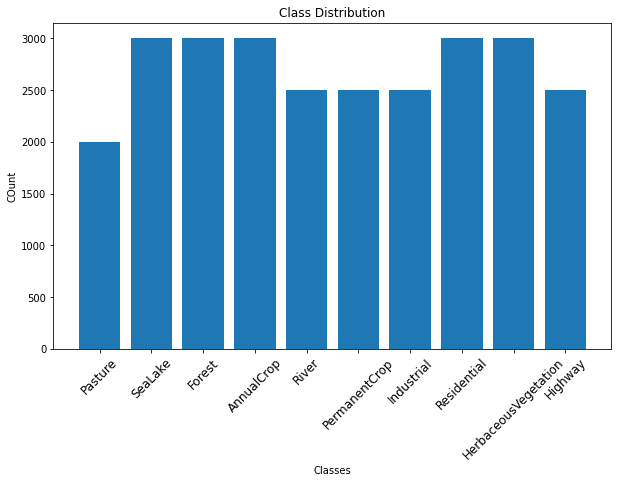

In [ ]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(base_path, l)))

    
plt.figure(figsize=(10, 6))

plt.bar(range(len(counts)), list(counts.values()))
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=45)
plt.xlabel('Classes')
plt.ylabel('COunt')
plt.title('Class Distribution');

Training images


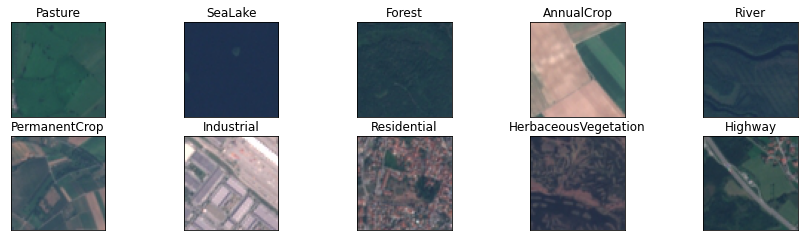

In [ ]:
img_paths = [os.path.join(base_path, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(base_path, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(10):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

print('Training images')
plot_sat_imgs(img_paths)

In [ ]:
# !rm -r TRAIN_DIR
# !rm -r TEST_DIR
!rm -r /content/UCMerced_LandUse/test
!rm -r /content/UCMerced_LandUse/train

rm: cannot remove '/content/UCMerced_LandUse/test': No such file or directory
rm: cannot remove '/content/UCMerced_LandUse/train': No such file or directory


In [ ]:
import re
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

# !rm -r TRAIN_DIR
# !rm -r TEST_DIR
TRAIN_DIR = '/content/Dataset/train/'
TEST_DIR = '/content/Dataset/test/'
TRAIN_DIR = "{}".format(TRAIN_DIR)
TEST_DIR = "{}".format(TEST_DIR)

!mkdir '/content/Dataset/train'
!mkdir '/content/Dataset/test'

BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

In [ ]:
# create class label subdirectories in train and test
for l in LABELS:
    # print(l)
    if not os.path.exists(TRAIN_DIR+l):
        os.mkdir(TRAIN_DIR+l)

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(TEST_DIR+l)

In [ ]:
# Split data for train and test images
data = {}

for l in LABELS:
    for img in os.listdir(base_path+'/'+l):
        data.update({os.path.join(base_path, l, img): l})

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=69)


for train_idx, test_idx in split.split(X, y):
    
    train_paths = X[train_idx]
    test_paths = X[test_idx]

    new_train_paths = [re.sub('/content/Dataset/2750', '/content/Dataset/train', i) for i in train_paths]
    new_test_paths = [re.sub('/content/Dataset/2750', '/content/Dataset/test', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))
    
    print("moving training files..")
    for i in tqdm(train_path_map):
      
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])
    print("moving testing files..")
    for i in tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

  6%|▌         | 1332/21600 [00:00<00:01, 13318.49it/s]

moving training files..


 23%|██▎       | 1217/5400 [00:00<00:00, 12167.92it/s]

moving testing files..


100%|██████████| 5400/5400 [00:00<00:00, 12109.54it/s]


In [ ]:
#  Train and test generator set 
from keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip = True)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=True,
    seed=69
)

# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [ ]:
print(train_generator.class_indices)
np.save('class_indices', train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


# Model Building

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import ResNet50, ResNet50V2, ResNet152V2
from keras.applications import InceptionV3, Xception

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, fbeta_score, accuracy_score

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [ ]:
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    
    if (cnn_base == 'ResNet50') or (cnn_base == 'ResNet50V2') or (cnn_base == 'ResNet152V2'):
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
       
    
    elif (cnn_base == 'VGG16') or (cnn_base == 'VGG19'):
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = conv_base.output
        top_model = Flatten()(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)
    
    
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    model = Model(inputs=conv_base.input, outputs=output_layer)
        
    if type(fine_tune) == int:
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])
    
    return model

def plot_history(history):
       
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.show();

def display_results(y_true, y_preds, class_labels):
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):

    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]
                
        plt.tight_layout()
        ax.set_title("{}\n({})".format(class_indices[pred_idx], class_indices[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))   

In [ ]:
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/VGG16.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

VGG16

In [ ]:
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
vgg16_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
______________________________________________________________

In [ ]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE
N_EPOCHS = 100

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/VGG16.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [ ]:
train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=50,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
337/337 [==============================] - 72s 115ms/step - loss: 5.4045 - categorical_accuracy: 0.4587 - val_loss: 0.9551 - val_categorical_accuracy: 0.6715

Epoch 00001: val_categorical_accuracy improved from -inf to 0.67150, saving model to ../working/VGG16.weights.best.hdf5
Epoch 2/50
337/337 [==============================] - 37s 109ms/step - loss: 1.1140 - categorical_accuracy: 0.6164 - val_loss: 0.7384 - val_categorical_accuracy: 0.7574

Epoch 00002: val_categorical_accuracy improved from 0.67150 to 0.75744, saving model to ../working/VGG16.weights.best.hdf5
Epoch 3/50
337/337 [==============================] - 37s 111ms/step - loss: 1.0594 - categorical_accuracy: 0.6314 - val_loss: 0.7804 - val_categorical_accuracy: 0.7372

Epoch 00003: val_categorical_accuracy did not improve from 0.75744
Epoch 4/50
337/337 [==============================] - 37s 110ms/step - loss: 1.0143 - categorical_accuracy: 0.6606 - val_loss: 0.7243 - val_categorical_accuracy: 0.7706

Epoch 0000

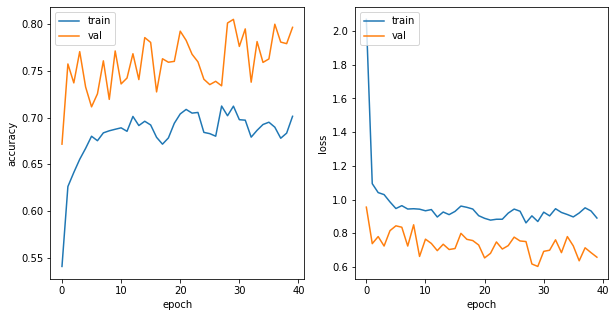

In [ ]:
plot_history(vgg16_history)

In [ ]:
# vgg16_model.load_weights('/content/drive/MyDrive/EuroSat/VGG16.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,
    seed=69
)

predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy: 0.7233333333333334
Global F2 Score: 0.7233333333333334


,Precision,Recall,F-Score,Support
AnnualCrop,0.365791,0.951667,0.528459,600.0
Forest,0.829377,0.931667,0.877551,600.0
HerbaceousVegetation,0.916268,0.638333,0.752456,600.0
Highway,0.705405,0.522000,0.600000,500.0
Industrial,0.901804,0.900000,0.900901,500.0
Pasture,0.807512,0.430000,0.561175,400.0
PermanentCrop,0.868996,0.398000,0.545953,500.0
Residential,0.869173,0.963333,0.913834,600.0
River,0.873950,0.416000,0.563686,500.0
SeaLake,0.984991,0.875000,0.926743,600.0
